In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print("Setup Complete")

Setup Complete


In [2]:
# Read the samples and convert to array
golden_normal_ppg_filepath = "golden_ppg_data_100hz.csv"

with open(golden_normal_ppg_filepath, 'r') as file:
    sample = sum(1 for _ in file)
    
golden_normal_ppg_data = pd.read_csv(golden_normal_ppg_filepath, nrows = sample)

signal = np.asarray(golden_normal_ppg_data, dtype = np.float64)

print(signal)

[[   1.49206795]
 [   6.17984449]
 [  17.42782314]
 ...
 [1323.15429395]
 [1265.30840879]
 [1175.63205982]]


In [3]:
# Shift the signal to eliminate negative values
min_signal = np.min(signal)
if min_signal < 0:
    signal = signal - min_signal  # Shift signal so the minimum value becomes 0 or greater

# Enhance signal
print(signal)

for i in range(len(signal)):
  signal[i] *= signal[i]

print(signal)

[[1636.89452287]
 [1641.58229941]
 [1652.83027806]
 ...
 [2958.55674887]
 [2900.71086371]
 [2811.03451474]]
[[2679423.67900743]
 [2694792.44574032]
 [2731847.92808267]
 ...
 [8753058.0362786 ]
 [8414123.51485592]
 [7901915.0430696 ]]


In [4]:
# Choose the Windows Size W1, W2 in TERMA framework
w_cycle =  55  # W2
w_evt = 9  # W1

ma_cycle = np.zeros_like(signal, dtype = np.float64)
ma_evt = np.zeros_like(signal, dtype = np.float64)

mean_signal = 0

# Calculate the Event Duration Moving Average
for i in range((w_evt - 1) // 2, len(signal) - ((w_evt - 1) // 2)):
    for j in range(-(w_evt - 1) // 2, (w_evt - 1) // 2):
        ma_evt[i] += signal[i + j]
    ma_evt[i] /= w_evt

# Calculate the Event Cycle Moving Average
for i in range((w_cycle - 1) // 2, len(signal) - ((w_cycle - 1) // 2)):
    for j in range(-(w_cycle - 1) // 2, (w_cycle - 1) // 2):
        ma_cycle[i] += signal[i + j]
    ma_cycle[i] /= w_cycle

# Calculate the mean of signal
for i in range(len(signal)):
    mean_signal += signal[i]
mean_signal /= len(signal)
mean = np.full(len(signal), mean_signal)

In [5]:
# Calculate the Threshold for detect Block of Interest
beta = 0.095
alpha = np.zeros_like(signal, dtype = np.float64)
threshold_1 = np.zeros_like(signal, dtype = np.float64)
block_of_interest = np.zeros_like(signal, dtype = np.float64)

for i in range(len(signal)):
  threshold_1[i] = ma_cycle[i] + beta * mean[i]

print(threshold_1)

# Generate the Block of Interest
for i in range(len(signal)):
  if (ma_evt[i] > threshold_1[i]) and (ma_cycle[i] != 0):
    block_of_interest[i] = 1
  else:
    block_of_interest[i] = 0

[[289800.41276245]
 [289800.41276245]
 [289800.41276245]
 ...
 [289800.41276245]
 [289800.41276245]
 [289800.41276245]]


In [6]:
# Peak detector
start_block = 0
stop_block = 0
peak = 0
peak_index = 0
peak_index_arr = np.zeros_like(signal, dtype = np.float64)
peak_arr = np.zeros_like(signal, dtype = np.float64)
block_num = 0

for i in range(len(block_of_interest) - 1):
  if (block_of_interest[i + 1] - block_of_interest[i]) == 1:
    start_block = i
  if (block_of_interest[i] - block_of_interest[i + 1]) == 1:
    stop_block = i
    if (stop_block - start_block) >= w_evt:
      peak = signal[start_block]
      for i in range(start_block, stop_block + 1):
        if signal[i] > peak:
          peak = signal[i]
          peak_index = i
      peak_arr[block_num] = peak
      peak_index_arr[block_num] = peak_index
      block_num += 1

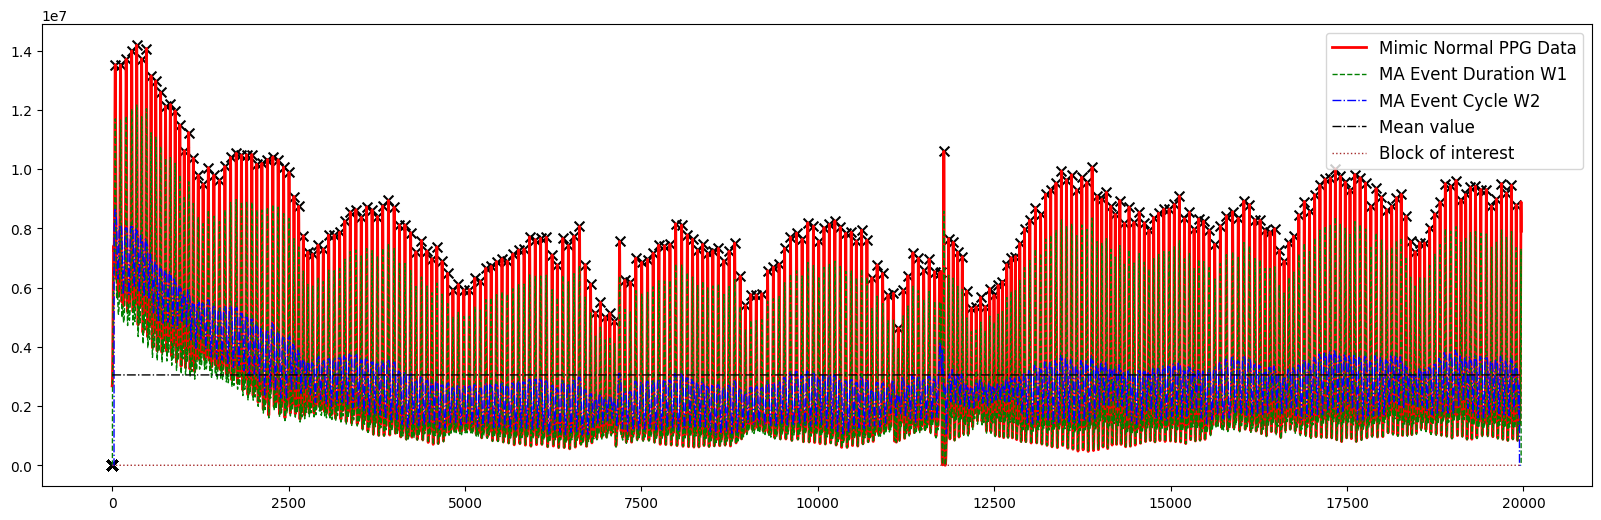

In [7]:
plt.figure(figsize = (20, 6))

x = np.arange(len(signal))

plt.plot(x, signal, linewidth = 2, color = 'red', label = 'Mimic Normal PPG Data')
plt.plot(x, ma_evt, linewidth = 1, color = 'green', linestyle = '--', label = 'MA Event Duration W1')
plt.plot(x, ma_cycle, linewidth = 1, color = 'blue', linestyle = '-.', label = 'MA Event Cycle W2')
plt.plot(x, mean, linewidth = 1, color = 'black', linestyle = '-.', label = 'Mean value')
plt.plot(x, block_of_interest, linewidth = 1, color = 'brown', linestyle = ':', label = 'Block of interest')


plt.scatter(peak_index_arr, peak_arr, s = 50, marker = 'x', c = 'black')
plt.legend(loc = 'upper right', bbox_to_anchor = (1, 1), fontsize = 12)

plt.show()
